# CIFAR-100 Training: ViT-Small vs ResNet18Small

⚠️ 중요: 모든 변수가 정상적으로 초기화되도록 반드시 처음부터 끝까지 (Cell 1 → Cell N) 모든 셀을 순서대로 실행하세요.

이 노트북은 **CIFAR-100 데이터셋(100 클래스)**을 사용하여 ViT-Small과 ResNet18Small 모델을 학습시키고, 두 모델의 성능을 비교합니다.

## 1. Library Import

Make sure to execute cells in order from top to bottom.

In [1]:
import os
# 현재 경로의 파일 목록 출력
print(os.listdir('.'))

['.config', 'sample_data']


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

## 2. 하이퍼파라미터 설정

In [3]:
# 학습 설정
BATCH_SIZE = 64  # 로컬 CPU에서 빠른 학습을 위해 줄임
NUM_EPOCHS = 20  # 빠른 실험을 위해 20 에포크로 설정
LEARNING_RATE = 1e-3  # 짧은 학습을 위해 learning rate 증가
IMAGE_SIZE = 32
PATCH_SIZE = 4
NUM_CLASSES = 100

# 디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# CIFAR-100 정규화 값
MEAN = (0.5071, 0.4867, 0.4408)
STD = (0.2675, 0.2565, 0.2761)

Using device: cuda


## 3. 데이터셋 준비

In [4]:
class SEBlock(nn.Module):
    def __init__(self, in_planes, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_planes, in_planes // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(in_planes // reduction, in_planes, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class BasicBlock(nn.Module):
    """
    ResNet의 기본 빌딩 블록 (BasicBlock)

    ResNet18과 ResNet34에서 사용되는 residual block입니다.
    두 개의 3x3 convolution layer로 구성되며, skip connection을 통해
    입력을 출력에 더해주는 구조입니다.

    구조:
        Input
          ├─→ Conv(3×3) → BN → ReLU → Conv(3×3) → BN ─→ + S-EBlock
          └────────────────────────────────────────────→ ↓
                                                      ReLU → Output

    Args:
        in_planes (int): 입력 채널 수
        planes (int): 출력 채널 수 (첫 번째 conv의 출력 채널)
        stride (int): stride 크기. 2일 경우 feature map 크기가 절반으로 줄어듦
    """
    expansion = 1  # BasicBlock은 채널 수 확장이 없음 (Bottleneck과 구분)

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # =========================
        # TODO 1) conv1, bn1 정의
        # - conv1은 3x3 Conv2d
        # - stride는 함수 인자로 받은 stride 사용
        # - padding=1, bias=False
        # =========================
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)  # nn.Conv2d(...)
        self.bn1 = nn.BatchNorm2d(planes)   # nn.BatchNorm2d(...)

        # =========================
        # TODO 2) conv2, bn2 정의
        # - conv2는 3x3 Conv2d
        # - stride=1 고정
        # - padding=1, bias=False
        # =========================
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)


        # (수정) S-EBlock 추가

        self.se = SEBlock(planes)

        # =========================
        # TODO 3) shortcut 정의
        # - 기본은 nn.Sequential() (identity처럼 동작)
        # - 만약 stride != 1 또는 in_planes != planes*self.expansion 이면
        #   1x1 Conv2d + BatchNorm2d 로 구성된 nn.Sequential로 교체
        # =========================
        self.shortcut = nn.Sequential()  # 기본값



        # Shortcut connection (skip connection)
        # 입력과 출력의 차원이 다를 경우 1x1 conv로 차원 맞춤
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),  # 1x1 conv: in_planes -> planes*expansion, stride=stride, bias=False
                nn.BatchNorm2d(self.expansion * planes)   # bn
            )


    def forward(self, x):
        """
        Forward pass

        Args:
            x: 입력 텐서 (batch_size, in_planes, H, W)

        Returns:
            출력 텐서 (batch_size, planes, H', W')
            H', W'는 stride에 따라 결정됨
        """
        # =========================
        # TODO 4) main path 구현
        # out = relu(bn1(conv1(x)))
        # out = bn2(conv2(out))
        # =========================
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # (수정)SEBlock 적용
        out = self.se(out)

        # =========================
        # TODO 5) skip connection 더하기
        # out += shortcut(x)
        # =========================
        out = out + self.shortcut(x)  # out + shortcut(x) 또는 out += shortcut(x)

        # =========================
        # TODO 6) 마지막 ReLU
        # =========================
        out = F.relu(out)



        return out


class ResNetSmall(nn.Module):
    """
    경량화된 ResNet18 모델 (ResNet18Small)

    원본 ResNet18의 채널 수를 약 37.5%로 줄여 파라미터 수를
    11.17M에서 1.58M으로 대폭 감소시킨 모델입니다.

    채널 구조 비교:
        ResNet18:      64 → 64  → 128 → 256 → 512
        ResNet18Small: 24 → 24  → 48  → 96  → 192

    구조:
        Input (32×32×3)
          ↓
        Conv1 (3×3, 24 channels)
          ↓
        Layer1: 2× BasicBlock (24 channels, stride=1)  → 32×32
          ↓
        Layer2: 2× BasicBlock (48 channels, stride=2)  → 16×16
          ↓
        Layer3: 2× BasicBlock (96 channels, stride=2)  → 8×8
          ↓
        Layer4: 2× BasicBlock (192 channels, stride=2) → 4×4
          ↓
        AvgPool (4×4) → FC (192 → num_classes)

    Args:
        block: 사용할 블록 타입 (BasicBlock 또는 Bottleneck)
        num_blocks: 각 layer의 블록 개수 리스트 [2,2,2,2]
        num_classes: 분류할 클래스 개수 (CIFAR-10: 10, CIFAR-100: 100)
    """

    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNetSmall, self).__init__()
        self.in_planes = 24  # 초기 채널 수 (원본 ResNet18의 64에서 24로 축소)

        # 첫 번째 convolution layer
        self.conv1 = nn.Conv2d(3, 24, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)

        # 4개의 residual layer 생성
        self.layer1 = self._make_layer(block, 24, num_blocks[0], stride=1)   # 32×32 유지
        self.layer2 = self._make_layer(block, 48, num_blocks[1], stride=2)   # 16×16
        self.layer3 = self._make_layer(block, 96, num_blocks[2], stride=2)   # 8×8
        self.layer4 = self._make_layer(block, 192, num_blocks[3], stride=2)  # 4×4

        # 최종 classification layer
        self.linear = nn.Linear(192 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        """
        Residual layer를 생성하는 헬퍼 함수

        각 layer는 여러 개의 residual block으로 구성됩니다.
        첫 번째 블록에서만 stride를 적용하여 downsampling하고,
        나머지 블록들은 stride=1로 feature map 크기를 유지합니다.

        Args:
            block: 블록 타입 (BasicBlock)
            planes: 출력 채널 수
            num_blocks: 이 layer에 포함될 블록 개수
            stride: 첫 번째 블록의 stride (downsampling 여부 결정)

        Returns:
            nn.Sequential: 여러 블록이 순차적으로 연결된 layer
        """
        strides = [stride] + [1] * (num_blocks - 1)  # [stride, 1, 1, ...]
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion  # 다음 블록의 입력 채널 수 업데이트

        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass

        Args:
            x: 입력 이미지 텐서 (batch_size, 3, 32, 32)

        Returns:
            출력 로짓 (batch_size, num_classes)
        """
        # Initial convolution
        out = F.relu(self.bn1(self.conv1(x)))  # (B, 24, 32, 32)

        # 4개의 residual layer 통과
        out = self.layer1(out)  # (B, 24, 32, 32)
        out = self.layer2(out)  # (B, 48, 16, 16)
        out = self.layer3(out)  # (B, 96, 8, 8)
        out = self.layer4(out)  # (B, 192, 4, 4)

        # Global average pooling
        out = F.avg_pool2d(out, 4)  # (B, 192, 1, 1)

        # Flatten
        out = out.view(out.size(0), -1)  # (B, 192)

        # Classification
        out = self.linear(out)  # (B, num_classes)

        return out


def ResNet18Small(num_classes=10):
    """
    ResNet18Small 모델 생성 함수

    Args:
        num_classes: 분류할 클래스 개수

    Returns:
        ResNet18Small 모델 (파라미터: ~1.58M)
    """
    return ResNetSmall(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

### data augmentation(TODO)

In [5]:
# 데이터 변환 정의
transform_train = transforms.Compose([
    #TODO: implement data augmentation
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),


    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

In [6]:


# 데이터셋 로드
print('==> Preparing data..')
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=0)

# CIFAR-100 has 100 classes
print(f'Training samples: {len(trainset)}, Test samples: {len(testset)}')

==> Preparing data..


100%|██████████| 169M/169M [00:13<00:00, 12.5MB/s]


Training samples: 50000, Test samples: 10000


### 3.1 데이터셋 예시 시각화

==> 데이터셋 샘플 시각화...


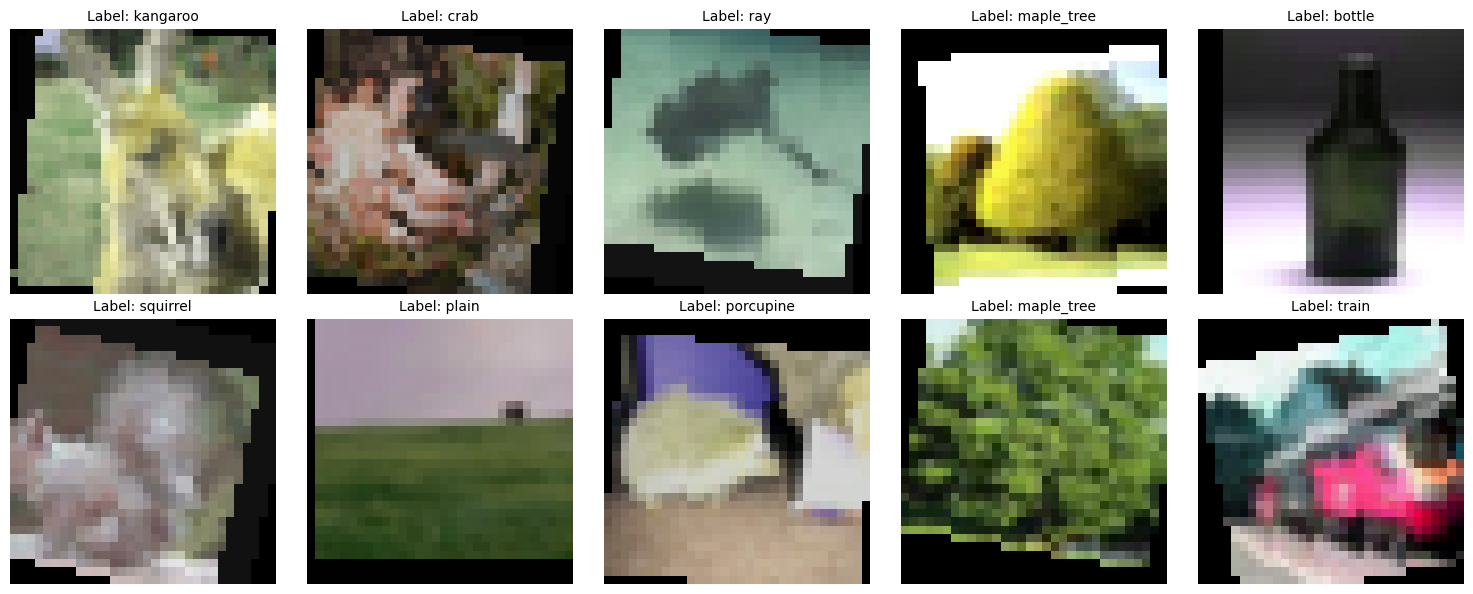


==> 데이터셋 샘플이 dataset_samples.png로 저장되었습니다.


In [7]:
def denormalize(tensor, mean, std):
    """
    정규화된 텐서를 원본 이미지로 복원하는 함수

    Args:
        tensor: 정규화된 이미지 텐서 (C, H, W)
        mean: 정규화에 사용된 평균값
        std: 정규화에 사용된 표준편차

    Returns:
        원본 범위 [0, 1]로 복원된 텐서
    """
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


def show_dataset_samples(dataset, classes, mean, std, num_samples=10):
    """
    데이터셋에서 무작위 샘플을 시각화하는 함수

    Args:
        dataset: 시각화할 데이터셋
        classes: 클래스 이름 리스트
        mean: 정규화 평균값
        std: 정규화 표준편차
        num_samples: 표시할 샘플 개수
    """
    # 무작위로 샘플 선택
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    # 그리드 설정 (2행 5열)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for idx, sample_idx in enumerate(indices):
        img, label = dataset[sample_idx]

        # 정규화 해제
        img = denormalize(img, mean, std)

        # 텐서를 numpy로 변환 (C, H, W) -> (H, W, C)
        img = img.permute(1, 2, 0).numpy()

        # [0, 1] 범위로 클리핑
        img = np.clip(img, 0, 1)

        # 이미지 표시
        axes[idx].imshow(img)
        axes[idx].set_title(f'Label: {classes[label]}', fontsize=10)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('dataset_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('\n==> 데이터셋 샘플이 dataset_samples.png로 저장되었습니다.')


# 데이터셋 샘플 시각화
print('==> 데이터셋 샘플 시각화...')
show_dataset_samples(trainset, trainset.classes, MEAN, STD, num_samples=10)

### 3.2 데이터 증강 (Augmentation) 효과 시각화

==> 데이터 증강 효과 시각화...


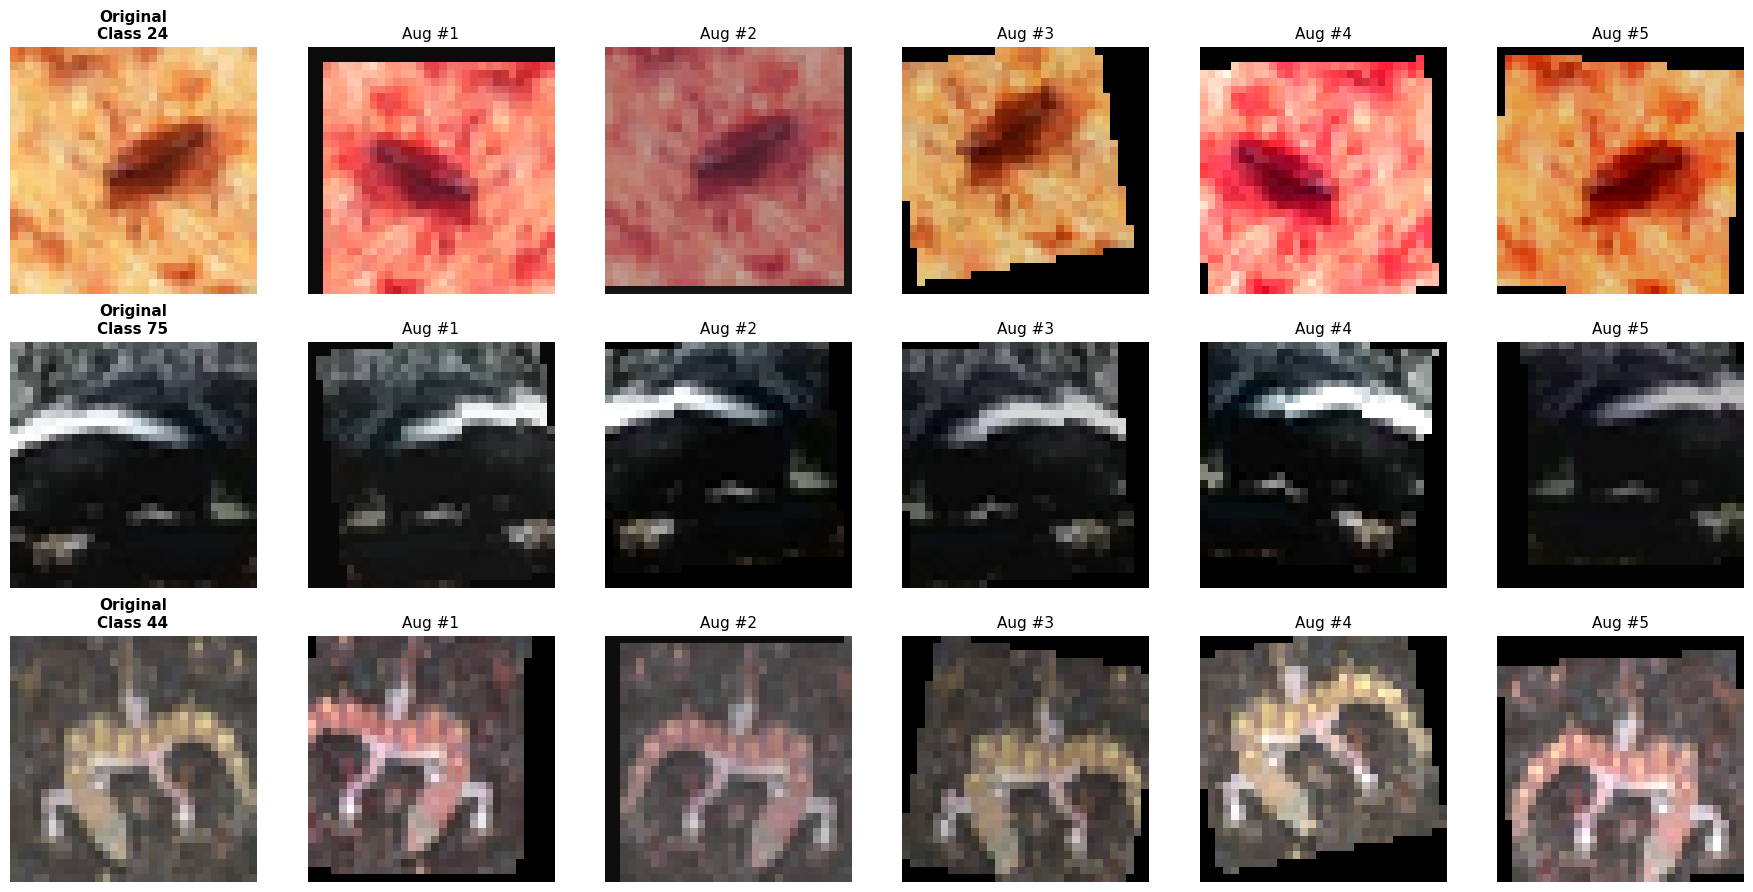

In [8]:
def show_augmentation_examples(num_samples=3, augmentations_per_image=5):
    """
    데이터 증강 효과를 시각화하는 함수

    원본 이미지 하나당 여러 번 증강을 적용하여 어떻게 변하는지 보여줍니다.

    Args:
        num_samples: 시각화할 원본 이미지 개수
        augmentations_per_image: 각 이미지당 생성할 증강 샘플 개수
    """
    # 증강 없는 데이터셋 (비교용)
    dataset_no_aug = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=False,
        transform=transforms.ToTensor()
    )

    # 증강 있는 변환 (정규화 제외)
    transform_aug_viz = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
    ])

    # 무작위로 이미지 선택
    indices = np.random.choice(len(dataset_no_aug), num_samples, replace=False)

    # 그리드 설정 (각 행: 원본 1개 + 증강 N개)
    fig, axes = plt.subplots(num_samples, augmentations_per_image + 1,
                            figsize=(3 * (augmentations_per_image + 1), 3 * num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for row, img_idx in enumerate(indices):
        # 원본 이미지 가져오기
        original_img, label = dataset_no_aug[img_idx]

        # 원본 이미지 표시
        original_np = original_img.permute(1, 2, 0).numpy()
        axes[row, 0].imshow(original_np)
        axes[row, 0].set_title(f'Original\nClass {label}', fontsize=11, fontweight='bold')
        axes[row, 0].axis('off')

        # 증강된 이미지들 표시
        # PIL 이미지로 변환 (transform 적용을 위해)
        from PIL import Image
        pil_img = Image.fromarray((original_np * 255).astype(np.uint8))

        for col in range(augmentations_per_image):
            # 증강 적용
            aug_img = transform_aug_viz(pil_img)
            aug_np = aug_img.permute(1, 2, 0).numpy()

            # 증강된 이미지 표시
            axes[row, col + 1].imshow(aug_np)
            axes[row, col + 1].set_title(f'Aug #{col+1}', fontsize=11)
            axes[row, col + 1].axis('off')

    plt.tight_layout()
    plt.show()


# 데이터 증강 효과 시각화
print('==> 데이터 증강 효과 시각화...')
show_augmentation_examples(num_samples=3, augmentations_per_image=5)

## 4. 모델 정의

### 4.1 ResNet18Small 모델

### 4.2 ViT-Small 모델

In [9]:
def pair(t):
    """
    단일 값을 튜플로 변환하는 헬퍼 함수

    이미 튜플이면 그대로 반환하고, 아니면 (t, t) 형태로 변환합니다.
    주로 image_size, patch_size 등을 처리할 때 사용합니다.

    Args:
        t: 정수 또는 튜플

    Returns:
        튜플 (t, t) 또는 원본 튜플
    """
    return t if isinstance(t, tuple) else (t, t)


class PreNorm(nn.Module):
    """
    LayerNorm을 먼저 적용한 후 함수를 실행하는 래퍼 클래스

    Transformer의 Pre-LayerNorm 구조를 구현합니다.
    일반적으로 Attention이나 FeedForward 전에 정규화를 수행합니다.

    Args:
        dim: 입력 차원
        fn: 적용할 함수 (Attention 또는 FeedForward)
    """
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        """정규화 후 함수 적용"""
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    """
    Transformer의 Feed-Forward Network (FFN)

    Position-wise fully connected feed-forward network입니다.
    두 개의 linear layer와 GELU 활성화 함수로 구성됩니다.

    구조:
        Input → Linear(dim → hidden_dim) → GELU → Dropout
              → Linear(hidden_dim → dim) → Dropout → Output

    Args:
        dim: 입력/출력 차원
        hidden_dim: 은닉층 차원 (일반적으로 dim의 4배)
        dropout: 드롭아웃 비율
    """
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        """FFN 적용"""
        return self.net(x)


class LSA(nn.Module):
    """
    Locality Self-Attention (LSA)

    일반적인 self-attention과 달리 자기 자신에 대한 attention을 mask하여
    지역적 정보(locality)를 강조하는 attention mechanism입니다.

    특징:
        - 자기 자신을 보지 못하도록 대각선 mask 적용
        - 온도 파라미터(temperature)를 학습 가능하게 설정
        - Multi-head attention 구조

    Args:
        dim: 입력 차원
        heads: attention head 개수
        dim_head: 각 head의 차원
        dropout: 드롭아웃 비율
    """
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads

        # 학습 가능한 temperature 파라미터 (스케일링 팩터)
        self.temperature = nn.Parameter(torch.log(torch.tensor(dim_head ** -0.5)))

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        """
        LSA forward pass

        Args:
            x: 입력 텐서 (batch, num_patches, dim)

        Returns:
            attention 적용된 출력 (batch, num_patches, dim)
        """
        # Q, K, V 생성
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        # Attention score 계산: Q @ K^T * temperature
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.temperature.exp()

        # 자기 자신에 대한 attention mask (대각선)
        mask = torch.eye(dots.shape[-1], device=dots.device, dtype=torch.bool)
        mask_value = -torch.finfo(dots.dtype).max
        dots = dots.masked_fill(mask, mask_value)

        # Softmax로 attention weights 계산
        attn = self.attend(dots)

        # Attention 적용: weights @ V
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')

        return self.to_out(out)


class Transformer(nn.Module):
    """
    Transformer Encoder

    여러 개의 Transformer block을 쌓아 구성합니다.
    각 block은 LSA + FFN으로 구성되며, residual connection이 적용됩니다.

    구조 (각 block마다):
        Input → PreNorm → LSA ─┬→ + → PreNorm → FFN ─┬→ + → Output
          └──────────────────┘              └──────────┘
          (residual connection)           (residual connection)

    Args:
        dim: 입력/출력 차원
        depth: Transformer block 개수
        heads: attention head 개수
        dim_head: 각 head의 차원
        mlp_dim: FFN의 은닉층 차원
        dropout: 드롭아웃 비율
    """
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])

        # depth 만큼 Transformer block 생성
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, LSA(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        """
        Transformer forward pass

        Args:
            x: 입력 텐서 (batch, num_patches+1, dim)

        Returns:
            변환된 출력 (batch, num_patches+1, dim)
        """
        # 각 Transformer block 통과
        for attn, ff in self.layers:
            x = attn(x) + x  # Attention + residual
            x = ff(x) + x    # FFN + residual

        return x


class SPT(nn.Module):
    """
    Shifted Patch Tokenization (SPT)

    일반적인 patch embedding과 달리, 원본 이미지와 shifted된 이미지들을
    함께 사용하여 더 풍부한 patch representation을 생성합니다.

    동작 방식:
        1. 원본 이미지 + 상하좌우로 1픽셀 shifted된 4개 이미지 = 총 5개
        2. 각각을 patch로 분할 (채널 방향으로 concatenate)
        3. Linear projection으로 embedding 차원으로 변환

    Args:
        dim: 출력 embedding 차원
        patch_size: 패치 크기
        channels: 입력 이미지 채널 수 (RGB: 3)
    """
    def __init__(self, *, dim, patch_size, channels=3):
        super().__init__()
        # 5개 이미지 (원본 + shifted 4개) × channels
        patch_dim = patch_size * patch_size * 5 * channels

        self.to_patch_tokens = nn.Sequential(
            # 이미지를 패치로 분할
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
                     p1=patch_size, p2=patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim)
        )

    def forward(self, x):
        """
        SPT forward pass

        Args:
            x: 입력 이미지 (batch, 3, H, W)

        Returns:
            패치 임베딩 (batch, num_patches, dim)
        """
        # 상하좌우로 1픽셀 shift (padding으로 구현)
        shifts = ((1, -1, 0, 0), (-1, 1, 0, 0), (0, 0, 1, -1), (0, 0, -1, 1))
        shifted_x = list(map(lambda shift: F.pad(x, shift), shifts))

        # 원본 + shifted 4개 = 5개를 채널 방향으로 concat
        x_with_shifts = torch.cat((x, *shifted_x), dim=1)  # (B, 15, H, W)

        # 패치로 변환 및 embedding
        return self.to_patch_tokens(x_with_shifts)


class ViT(nn.Module):
    """
    Vision Transformer (ViT) with Shifted Patch Tokenization

    이미지 분류를 위한 Transformer 모델입니다.
    SPT를 사용하여 이미지를 패치로 변환하고, Transformer encoder로 처리한 뒤
    classification head로 최종 예측을 수행합니다.

    전체 구조:
        Input Image (32×32×3)
          ↓
        SPT (Shifted Patch Tokenization)
          ↓
        Patch Embeddings (64 patches × dim)
          ↓
        + CLS Token + Positional Embedding
          ↓
        Dropout
          ↓
        Transformer Encoder (depth layers)
          ↓
        CLS Token 추출 (또는 mean pooling)
          ↓
        MLP Head (LayerNorm → Linear)
          ↓
        Classification Output (num_classes)

    Args:
        image_size: 입력 이미지 크기 (정사각형)
        patch_size: 패치 크기
        num_classes: 분류할 클래스 개수
        dim: embedding 차원
        depth: Transformer block 개수
        heads: attention head 개수
        mlp_dim: FFN 은닉층 차원
        pool: pooling 방식 ('cls' 또는 'mean')
        channels: 입력 이미지 채널 수
        dim_head: 각 attention head의 차원
        dropout: attention/FFN dropout 비율
        emb_dropout: embedding dropout 비율
    """
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads,
                 mlp_dim, pool='cls', channels=3, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        # 이미지가 패치 크기로 나누어떨어지는지 확인
        assert image_height % patch_height == 0 and image_width % patch_width == 0, \
            'Image dimensions must be divisible by the patch size.'

        # 패치 개수 계산
        num_patches = (image_height // patch_height) * (image_width // patch_width)

        assert pool in {'cls', 'mean'}, 'pool type must be either cls or mean'

        # TODO 1) patch embedding
        self.to_patch_embedding = SPT(dim=dim, patch_size=patch_size, channels=channels)

        # TODO 2) cls token, positional embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        # TODO 3) dropout, transformer, head
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        self.pool = pool
        self.to_latent = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        """
        ViT forward pass

        Args:
            img: 입력 이미지 (batch, 3, H, W)

        Returns:
            분류 로짓 (batch, num_classes)
        """
        # TODO 5) patch embedding
        x = self.to_patch_embedding(img)  # (B, num_patches, dim)
        b, n, _ = x.shape

        # TODO 6) cls token concat
        cls_tokens = self.cls_token.expand(b, -1, -1)  # (B, 1, dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, num_patches+1, dim)

        # TODO 7) pos embedding + dropout
        x = x + self.pos_embedding[:, :n + 1, :]
        x = self.dropout(x)

        # TODO 8) transformer
        x = self.transformer(x)

        # TODO 9) pooling
        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]

        # TODO 10) classification head
        x = self.to_latent(x)
        return self.mlp_head(x)


def create_vit_small():
    """
    ViT-Small 모델 생성 함수

    경량화된 ViT 모델로, 다음과 같은 설정을 사용합니다:
        - Embedding dim: 256 (표준 ViT의 768에서 축소)
        - Depth: 4 layers (표준 ViT의 12에서 축소)
        - Heads: 4 (표준 ViT의 12에서 축소)
        - MLP dim: 256 (표준 ViT의 3072에서 축소)

    Returns:
        ViT 모델 (파라미터: ~1.66M)
    """
    model = ViT(
        image_size=IMAGE_SIZE,      # 32
        patch_size=PATCH_SIZE,       # 4
        num_classes=NUM_CLASSES,     # 100
        dim=256,                      # Embedding 차원
        depth=4,                      # Transformer layers
        heads=4,                      # Attention heads
        mlp_dim=256,                  # FFN hidden dim
        dropout=0.1,
        emb_dropout=0.1
    )
    return model


def create_resnet18_small():
    """
    ResNet18Small 모델 생성 함수

    Returns:
        ResNet18Small 모델 (파라미터: ~1.58M)
    """
    model = ResNet18Small(num_classes=NUM_CLASSES)
    return model

## 5. 학습 및 평가 함수

In [10]:
def train_epoch(model, trainloader, criterion, optimizer, device):
    """한 에포크 학습"""
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(trainloader, desc='Training')
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        pbar.set_postfix({'loss': train_loss/(pbar.n+1), 'acc': 100.*correct/total})

    return train_loss/len(trainloader), 100.*correct/total

def evaluate(model, testloader, criterion, device):
    """모델 평가"""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(testloader, desc='Testing')
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            pbar.set_postfix({'loss': test_loss/(pbar.n+1), 'acc': 100.*correct/total})

    return test_loss/len(testloader), 100.*correct/total

## 6. 전체 학습 함수

In [11]:
def train_model(model, model_name, num_epochs=NUM_EPOCHS):
    """모델 학습 전체 프로세스"""
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

    # 기록용
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'lr': []
    }

    best_acc = 0

    print(f'\n==> Training {model_name}...')
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f'\nEpoch: {epoch+1}/{num_epochs}')

        # 학습
        train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)

        # 평가
        test_loss, test_acc = evaluate(model, testloader, criterion, device)

        # 스케줄러 업데이트
        scheduler.step()

        # 기록
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # 결과 출력
        print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')
        print(f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

        # 베스트 모델 저장
        if test_acc > best_acc:
            best_acc = test_acc
            print(f'==> Saving best model.. (Acc: {best_acc:.2f}%)')

    total_time = time.time() - start_time
    print(f'\nTraining completed in {total_time/60:.2f} minutes')
    print(f'Best Test Accuracy: {best_acc:.2f}%')

    return history, best_acc

## 7. ViT-Small 학습

In [12]:
# ViT-Small 모델 생성 및 학습
vit_model = create_vit_small()
print(f'ViT-Small Parameters: {sum(p.numel() for p in vit_model.parameters())/1e6:.2f}M')

vit_history, vit_best_acc = train_model(vit_model, 'ViT-Small', num_epochs=NUM_EPOCHS)

ViT-Small Parameters: 1.69M

==> Training ViT-Small...

Epoch: 1/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 35.87it/s, loss=3.82, acc=12.6]


Train Loss: 4.076 | Train Acc: 7.54%
Test Loss: 3.707 | Test Acc: 12.61%
LR: 0.000994
==> Saving best model.. (Acc: 12.61%)

Epoch: 2/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.80it/s, loss=3.49, acc=17.9]


Train Loss: 3.660 | Train Acc: 13.52%
Test Loss: 3.384 | Test Acc: 17.95%
LR: 0.000976
==> Saving best model.. (Acc: 17.95%)

Epoch: 3/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 35.76it/s, loss=3.26, acc=22.4]


Train Loss: 3.424 | Train Acc: 17.69%
Test Loss: 3.167 | Test Acc: 22.43%
LR: 0.000946
==> Saving best model.. (Acc: 22.43%)

Epoch: 4/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.23it/s, loss=3.12, acc=24.3]


Train Loss: 3.260 | Train Acc: 20.53%
Test Loss: 3.030 | Test Acc: 24.29%
LR: 0.000905
==> Saving best model.. (Acc: 24.29%)

Epoch: 5/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.25it/s, loss=3, acc=27.6]


Train Loss: 3.124 | Train Acc: 23.03%
Test Loss: 2.905 | Test Acc: 27.55%
LR: 0.000854
==> Saving best model.. (Acc: 27.55%)

Epoch: 6/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.55it/s, loss=2.85, acc=29.8]


Train Loss: 3.007 | Train Acc: 25.36%
Test Loss: 2.764 | Test Acc: 29.80%
LR: 0.000794
==> Saving best model.. (Acc: 29.80%)

Epoch: 7/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.30it/s, loss=2.77, acc=30.9]


Train Loss: 2.902 | Train Acc: 27.34%
Test Loss: 2.686 | Test Acc: 30.95%
LR: 0.000727
==> Saving best model.. (Acc: 30.95%)

Epoch: 8/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.16it/s, loss=2.76, acc=31.7]


Train Loss: 2.805 | Train Acc: 29.04%
Test Loss: 2.677 | Test Acc: 31.74%
LR: 0.000655
==> Saving best model.. (Acc: 31.74%)

Epoch: 9/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.16it/s, loss=2.57, acc=35.8]


Train Loss: 2.715 | Train Acc: 31.07%
Test Loss: 2.490 | Test Acc: 35.80%
LR: 0.000578
==> Saving best model.. (Acc: 35.80%)

Epoch: 10/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.43it/s, loss=2.49, acc=37.7]


Train Loss: 2.634 | Train Acc: 32.58%
Test Loss: 2.413 | Test Acc: 37.74%
LR: 0.000500
==> Saving best model.. (Acc: 37.74%)

Epoch: 11/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 35.80it/s, loss=2.47, acc=37.7]


Train Loss: 2.544 | Train Acc: 34.47%
Test Loss: 2.400 | Test Acc: 37.72%
LR: 0.000422

Epoch: 12/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.91it/s, loss=2.38, acc=39.8]


Train Loss: 2.476 | Train Acc: 36.00%
Test Loss: 2.309 | Test Acc: 39.79%
LR: 0.000345
==> Saving best model.. (Acc: 39.79%)

Epoch: 13/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.51it/s, loss=2.33, acc=41.3]


Train Loss: 2.414 | Train Acc: 37.26%
Test Loss: 2.259 | Test Acc: 41.26%
LR: 0.000273
==> Saving best model.. (Acc: 41.26%)

Epoch: 14/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.00it/s, loss=2.28, acc=42.5]


Train Loss: 2.347 | Train Acc: 38.68%
Test Loss: 2.212 | Test Acc: 42.49%
LR: 0.000206
==> Saving best model.. (Acc: 42.49%)

Epoch: 15/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.04it/s, loss=2.26, acc=42.6]


Train Loss: 2.292 | Train Acc: 39.86%
Test Loss: 2.189 | Test Acc: 42.59%
LR: 0.000146
==> Saving best model.. (Acc: 42.59%)

Epoch: 16/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.52it/s, loss=2.21, acc=43.7]


Train Loss: 2.248 | Train Acc: 40.79%
Test Loss: 2.139 | Test Acc: 43.72%
LR: 0.000095
==> Saving best model.. (Acc: 43.72%)

Epoch: 17/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.47it/s, loss=2.18, acc=44.4]


Train Loss: 2.208 | Train Acc: 41.79%
Test Loss: 2.118 | Test Acc: 44.39%
LR: 0.000054
==> Saving best model.. (Acc: 44.39%)

Epoch: 18/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.43it/s, loss=2.18, acc=44.5]


Train Loss: 2.174 | Train Acc: 42.56%
Test Loss: 2.111 | Test Acc: 44.52%
LR: 0.000024
==> Saving best model.. (Acc: 44.52%)

Epoch: 19/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 35.67it/s, loss=2.16, acc=44.9]


Train Loss: 2.155 | Train Acc: 43.01%
Test Loss: 2.095 | Test Acc: 44.86%
LR: 0.000006
==> Saving best model.. (Acc: 44.86%)

Epoch: 20/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.90it/s, loss=2.16, acc=44.8]

Train Loss: 2.150 | Train Acc: 42.93%
Test Loss: 2.091 | Test Acc: 44.80%
LR: 0.000000

Training completed in 20.46 minutes
Best Test Accuracy: 44.86%


## 8. ResNet18Small 학습

In [13]:
# ResNet18Small 모델 생성 및 학습
resnet_model = create_resnet18_small()
print(f'ResNet18Small Parameters: {sum(p.numel() for p in resnet_model.parameters())/1e6:.2f}M')

resnet_history, resnet_best_acc = train_model(resnet_model, 'ResNet18Small', num_epochs=NUM_EPOCHS)

ResNet18Small Parameters: 1.60M

==> Training ResNet18Small...

Epoch: 1/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 34.97it/s, loss=3.43, acc=16.9]


Train Loss: 3.848 | Train Acc: 10.21%
Test Loss: 3.427 | Test Acc: 16.88%
LR: 0.000994
==> Saving best model.. (Acc: 16.88%)

Epoch: 2/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 35.72it/s, loss=2.98, acc=26.6]


Train Loss: 3.241 | Train Acc: 20.06%
Test Loss: 2.892 | Test Acc: 26.59%
LR: 0.000976
==> Saving best model.. (Acc: 26.59%)

Epoch: 3/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.47it/s, loss=2.56, acc=35.2]


Train Loss: 2.801 | Train Acc: 28.67%
Test Loss: 2.484 | Test Acc: 35.20%
LR: 0.000946
==> Saving best model.. (Acc: 35.20%)

Epoch: 4/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 35.35it/s, loss=2.7, acc=34.5]


Train Loss: 2.491 | Train Acc: 34.87%
Test Loss: 2.623 | Test Acc: 34.50%
LR: 0.000905

Epoch: 5/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 34.89it/s, loss=2.15, acc=44.1]


Train Loss: 2.269 | Train Acc: 39.65%
Test Loss: 2.086 | Test Acc: 44.06%
LR: 0.000854
==> Saving best model.. (Acc: 44.06%)

Epoch: 6/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 34.42it/s, loss=2.03, acc=47.3]


Train Loss: 2.102 | Train Acc: 43.40%
Test Loss: 1.967 | Test Acc: 47.33%
LR: 0.000794
==> Saving best model.. (Acc: 47.33%)

Epoch: 7/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 35.63it/s, loss=1.99, acc=47.1]


Train Loss: 1.957 | Train Acc: 46.77%
Test Loss: 1.934 | Test Acc: 47.12%
LR: 0.000727

Epoch: 8/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.73it/s, loss=1.83, acc=51.9]


Train Loss: 1.836 | Train Acc: 49.77%
Test Loss: 1.775 | Test Acc: 51.92%
LR: 0.000655
==> Saving best model.. (Acc: 51.92%)

Epoch: 9/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.26it/s, loss=1.71, acc=54.2]


Train Loss: 1.734 | Train Acc: 51.91%
Test Loss: 1.658 | Test Acc: 54.16%
LR: 0.000578
==> Saving best model.. (Acc: 54.16%)

Epoch: 10/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 35.67it/s, loss=1.69, acc=54.4]


Train Loss: 1.642 | Train Acc: 54.13%
Test Loss: 1.644 | Test Acc: 54.36%
LR: 0.000500
==> Saving best model.. (Acc: 54.36%)

Epoch: 11/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 35.94it/s, loss=1.66, acc=55.9]


Train Loss: 1.559 | Train Acc: 56.34%
Test Loss: 1.606 | Test Acc: 55.87%
LR: 0.000422
==> Saving best model.. (Acc: 55.87%)

Epoch: 12/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 35.97it/s, loss=1.57, acc=57.8]


Train Loss: 1.479 | Train Acc: 58.13%
Test Loss: 1.525 | Test Acc: 57.82%
LR: 0.000345
==> Saving best model.. (Acc: 57.82%)

Epoch: 13/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 35.98it/s, loss=1.58, acc=57.5]


Train Loss: 1.413 | Train Acc: 59.91%
Test Loss: 1.537 | Test Acc: 57.50%
LR: 0.000273

Epoch: 14/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.06it/s, loss=1.51, acc=59.1]


Train Loss: 1.353 | Train Acc: 61.34%
Test Loss: 1.467 | Test Acc: 59.08%
LR: 0.000206
==> Saving best model.. (Acc: 59.08%)

Epoch: 15/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 35.42it/s, loss=1.47, acc=60.3]


Train Loss: 1.295 | Train Acc: 63.23%
Test Loss: 1.425 | Test Acc: 60.32%
LR: 0.000146
==> Saving best model.. (Acc: 60.32%)

Epoch: 16/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.07it/s, loss=1.43, acc=61.7]


Train Loss: 1.251 | Train Acc: 64.05%
Test Loss: 1.387 | Test Acc: 61.73%
LR: 0.000095
==> Saving best model.. (Acc: 61.73%)

Epoch: 17/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 35.94it/s, loss=1.42, acc=61.7]


Train Loss: 1.217 | Train Acc: 65.00%
Test Loss: 1.382 | Test Acc: 61.68%
LR: 0.000054

Epoch: 18/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.25it/s, loss=1.42, acc=61.5]


Train Loss: 1.188 | Train Acc: 65.80%
Test Loss: 1.380 | Test Acc: 61.48%
LR: 0.000024

Epoch: 19/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 36.19it/s, loss=1.42, acc=61.7]


Train Loss: 1.169 | Train Acc: 66.29%
Test Loss: 1.374 | Test Acc: 61.67%
LR: 0.000006

Epoch: 20/20


Testing: 100%|██████████| 100/100 [00:02<00:00, 35.72it/s, loss=1.42, acc=61.8]

Train Loss: 1.162 | Train Acc: 66.14%
Test Loss: 1.376 | Test Acc: 61.76%
LR: 0.000000
==> Saving best model.. (Acc: 61.76%)

Training completed in 21.24 minutes
Best Test Accuracy: 61.76%


In [14]:
def count_parameters(model):
    """
    모델의 총 파라미터 수를 계산

    Args:
        model: PyTorch 모델

    Returns:
        파라미터 수 (정수)
    """
    return sum(p.numel() for p in model.parameters())


def calculate_flops_vit(model, image_size=32, patch_size=4):
    """
    ViT 모델의 FLOPs 계산 (근사값)

    Args:
        model: ViT 모델
        image_size: 입력 이미지 크기
        patch_size: 패치 크기

    Returns:
        FLOPs (부동소수점 연산 횟수)
    """
    num_patches = (image_size // patch_size) ** 2

    # Patch embedding: SPT 사용 (5개 이미지 concat)
    patch_dim = patch_size * patch_size * 3 * 5
    embed_dim = model.to_patch_embedding.to_patch_tokens[-1].out_features
    embedding_flops = num_patches * patch_dim * embed_dim

    # Transformer blocks
    depth = len(model.transformer.layers)
    seq_len = num_patches + 1  # +1 for CLS token

    # Self-attention per block
    # Q, K, V projection: 3 * seq_len * embed_dim * embed_dim
    # Attention: seq_len * seq_len * embed_dim
    # Output projection: seq_len * embed_dim * embed_dim
    attn_flops_per_block = (
        3 * seq_len * embed_dim * embed_dim +  # QKV projection
        seq_len * seq_len * embed_dim +         # Attention computation
        seq_len * embed_dim * embed_dim         # Output projection
    )

    # FFN per block
    # Linear1: seq_len * embed_dim * mlp_dim
    # Linear2: seq_len * mlp_dim * embed_dim
    mlp_dim = model.transformer.layers[0][1].fn.net[0].out_features
    ffn_flops_per_block = (
        seq_len * embed_dim * mlp_dim +
        seq_len * mlp_dim * embed_dim
    )

    transformer_flops = depth * (attn_flops_per_block + ffn_flops_per_block)

    # Classification head
    head_flops = embed_dim * model.mlp_head[-1].out_features

    total_flops = embedding_flops + transformer_flops + head_flops
    return total_flops


def calculate_flops_resnet(model, image_size=32):
    """
    ResNet 모델의 FLOPs 계산 (근사값)

    Args:
        model: ResNet 모델
        image_size: 입력 이미지 크기

    Returns:
        FLOPs (부동소수점 연산 횟수)
    """
    def conv_flops(in_channels, out_channels, kernel_size, h, w, stride=1):
        """Convolution FLOPs 계산"""
        out_h = h // stride
        out_w = w // stride
        return kernel_size * kernel_size * in_channels * out_channels * out_h * out_w

    flops = 0
    h, w = image_size, image_size

    # Initial conv: 3x3, 3->24
    flops += conv_flops(3, 24, 3, h, w)

    # Layer1: 2 blocks, 24->24, stride=1
    for _ in range(2):
        flops += conv_flops(24, 24, 3, h, w)  # conv1
        flops += conv_flops(24, 24, 3, h, w)  # conv2

    # Layer2: 2 blocks, 24->48, stride=2 (first), then 48->48
    h, w = h // 2, w // 2
    flops += conv_flops(24, 48, 3, h*2, w*2, stride=2)  # first conv1
    flops += conv_flops(48, 48, 3, h, w)  # first conv2
    flops += conv_flops(24, 48, 1, h*2, w*2, stride=2)  # shortcut
    flops += conv_flops(48, 48, 3, h, w)  # second conv1
    flops += conv_flops(48, 48, 3, h, w)  # second conv2

    # Layer3: 2 blocks, 48->96, stride=2 (first), then 96->96
    h, w = h // 2, w // 2
    flops += conv_flops(48, 96, 3, h*2, w*2, stride=2)  # first conv1
    flops += conv_flops(96, 96, 3, h, w)  # first conv2
    flops += conv_flops(48, 96, 1, h*2, w*2, stride=2)  # shortcut
    flops += conv_flops(96, 96, 3, h, w)  # second conv1
    flops += conv_flops(96, 96, 3, h, w)  # second conv2

    # Layer4: 2 blocks, 96->192, stride=2 (first), then 192->192
    h, w = h // 2, w // 2
    flops += conv_flops(96, 192, 3, h*2, w*2, stride=2)  # first conv1
    flops += conv_flops(192, 192, 3, h, w)  # first conv2
    flops += conv_flops(96, 192, 1, h*2, w*2, stride=2)  # shortcut
    flops += conv_flops(192, 192, 3, h, w)  # second conv1
    flops += conv_flops(192, 192, 3, h, w)  # second conv2

    # FC layer
    flops += 192 * model.linear.out_features

    return flops


# 모델 효율성 지표 계산
print('==> 모델 효율성 지표 계산 중...\n')

models_info = []

# ViT-Small
vit_params = count_parameters(vit_model)
vit_flops = calculate_flops_vit(vit_model)
models_info.append({
    'name': 'ViT-Small',
    'type': 'ViT',
    'params': vit_params,
    'flops': vit_flops,
    'accuracy': vit_best_acc,
    'marker': 'o',
    'color': 'blue'
})

# ResNet18Small
resnet_params = count_parameters(resnet_model)
resnet_flops = calculate_flops_resnet(resnet_model)
models_info.append({
    'name': 'ResNet18Small',
    'type': 'CNN',
    'params': resnet_params,
    'flops': resnet_flops,
    'accuracy': resnet_best_acc,
    'marker': 's',
    'color': 'red'
})

# 결과 출력
print('모델 효율성 지표:')
print('='*80)
for model in models_info:
    acc_per_param = model['accuracy'] / model['params']
    acc_per_flop = model['accuracy'] / model['flops']

    print(f"\n{model['name']} ({model['type']}):")
    print(f"  - Parameters: {model['params']:,} ({model['params']/1e6:.2f}M)")
    print(f"  - FLOPs: {model['flops']:,} ({model['flops']/1e6:.2f}M)")
    print(f"  - Test Accuracy: {model['accuracy']:.2f}%")
    print(f"  - Accuracy per Param: {acc_per_param:.6e}")
    print(f"  - Accuracy per FLOP:  {acc_per_flop:.6e}")
print('='*80)

==> 모델 효율성 지표 계산 중...

모델 효율성 지표:

ViT-Small (ViT):
  - Parameters: 1,685,320 (1.69M)
  - FLOPs: 110,520,320 (110.52M)
  - Test Accuracy: 44.86%
  - Accuracy per Param: 2.661809e-05
  - Accuracy per FLOP:  4.058982e-07

ResNet18Small (CNN):
  - Parameters: 1,604,764 (1.60M)
  - FLOPs: 78,539,520 (78.54M)
  - Test Accuracy: 61.76%
  - Accuracy per Param: 3.848541e-05
  - Accuracy per FLOP:  7.863557e-07


## 9. 결과 시각화

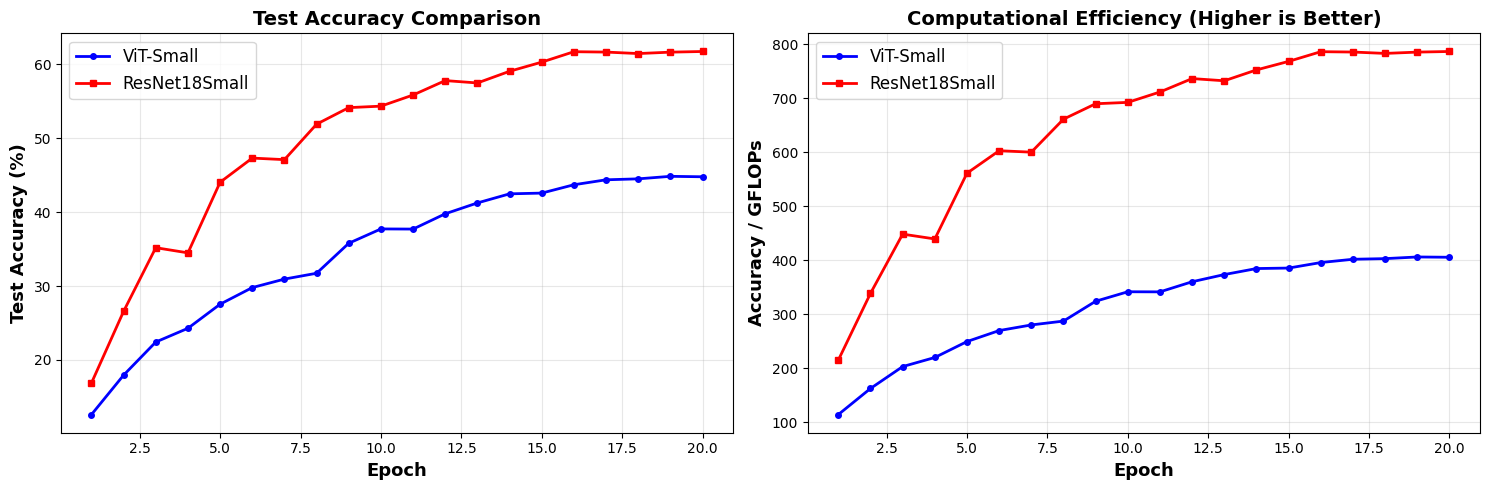


==> Training comparison graph saved as training_comparison.png


In [15]:
# CIFAR-10 학습 결과 그래프
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, NUM_EPOCHS + 1)

# Test Accuracy
axes[0].plot(epochs, vit_history['test_acc'], 'b-', label='ViT-Small', linewidth=2, marker='o', markersize=4)
axes[0].plot(epochs, resnet_history['test_acc'], 'r-', label='ResNet18Small', linewidth=2, marker='s', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Test Accuracy (%)', fontsize=13, fontweight='bold')
axes[0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# Accuracy per FLOPs (효율성)
vit_flops_per_epoch = vit_flops  # FLOPs per forward pass
resnet_flops_per_epoch = resnet_flops

axes[1].plot(epochs, [acc / (vit_flops_per_epoch / 1e9) for acc in vit_history['test_acc']],
             'b-', label='ViT-Small', linewidth=2, marker='o', markersize=4)
axes[1].plot(epochs, [acc / (resnet_flops_per_epoch / 1e9) for acc in resnet_history['test_acc']],
             'r-', label='ResNet18Small', linewidth=2, marker='s', markersize=4)
axes[1].set_xlabel('Epoch', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Accuracy / GFLOPs', fontsize=13, fontweight='bold')
axes[1].set_title('Computational Efficiency (Higher is Better)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n==> Training comparison graph saved as training_comparison.png')

## 10. 최종 결과 요약

In [16]:
print('\n' + '='*60)
print('CIFAR-10 Training Results'.center(60))
print('='*60)
print(f'\nViT-Small:')
print(f'  - Parameters: {sum(p.numel() for p in vit_model.parameters())/1e6:.2f}M')
print(f'  - Best Test Accuracy: {vit_best_acc:.2f}%')
print(f'  - Final Train Accuracy: {vit_history["train_acc"][-1]:.2f}%')
print(f'  - Final Test Accuracy: {vit_history["test_acc"][-1]:.2f}%')

print(f'\nResNet18Small:')
print(f'  - Parameters: {sum(p.numel() for p in resnet_model.parameters())/1e6:.2f}M')
print(f'  - Best Test Accuracy: {resnet_best_acc:.2f}%')
print(f'  - Final Train Accuracy: {resnet_history["train_acc"][-1]:.2f}%')
print(f'  - Final Test Accuracy: {resnet_history["test_acc"][-1]:.2f}%')

print('\n' + '='*60)


                 CIFAR-10 Training Results                  

ViT-Small:
  - Parameters: 1.69M
  - Best Test Accuracy: 44.86%
  - Final Train Accuracy: 42.93%
  - Final Test Accuracy: 44.80%

ResNet18Small:
  - Parameters: 1.60M
  - Best Test Accuracy: 61.76%
  - Final Train Accuracy: 66.14%
  - Final Test Accuracy: 61.76%



## 11. 모델 추론 결과 시각화


==> Visualizing model predictions...


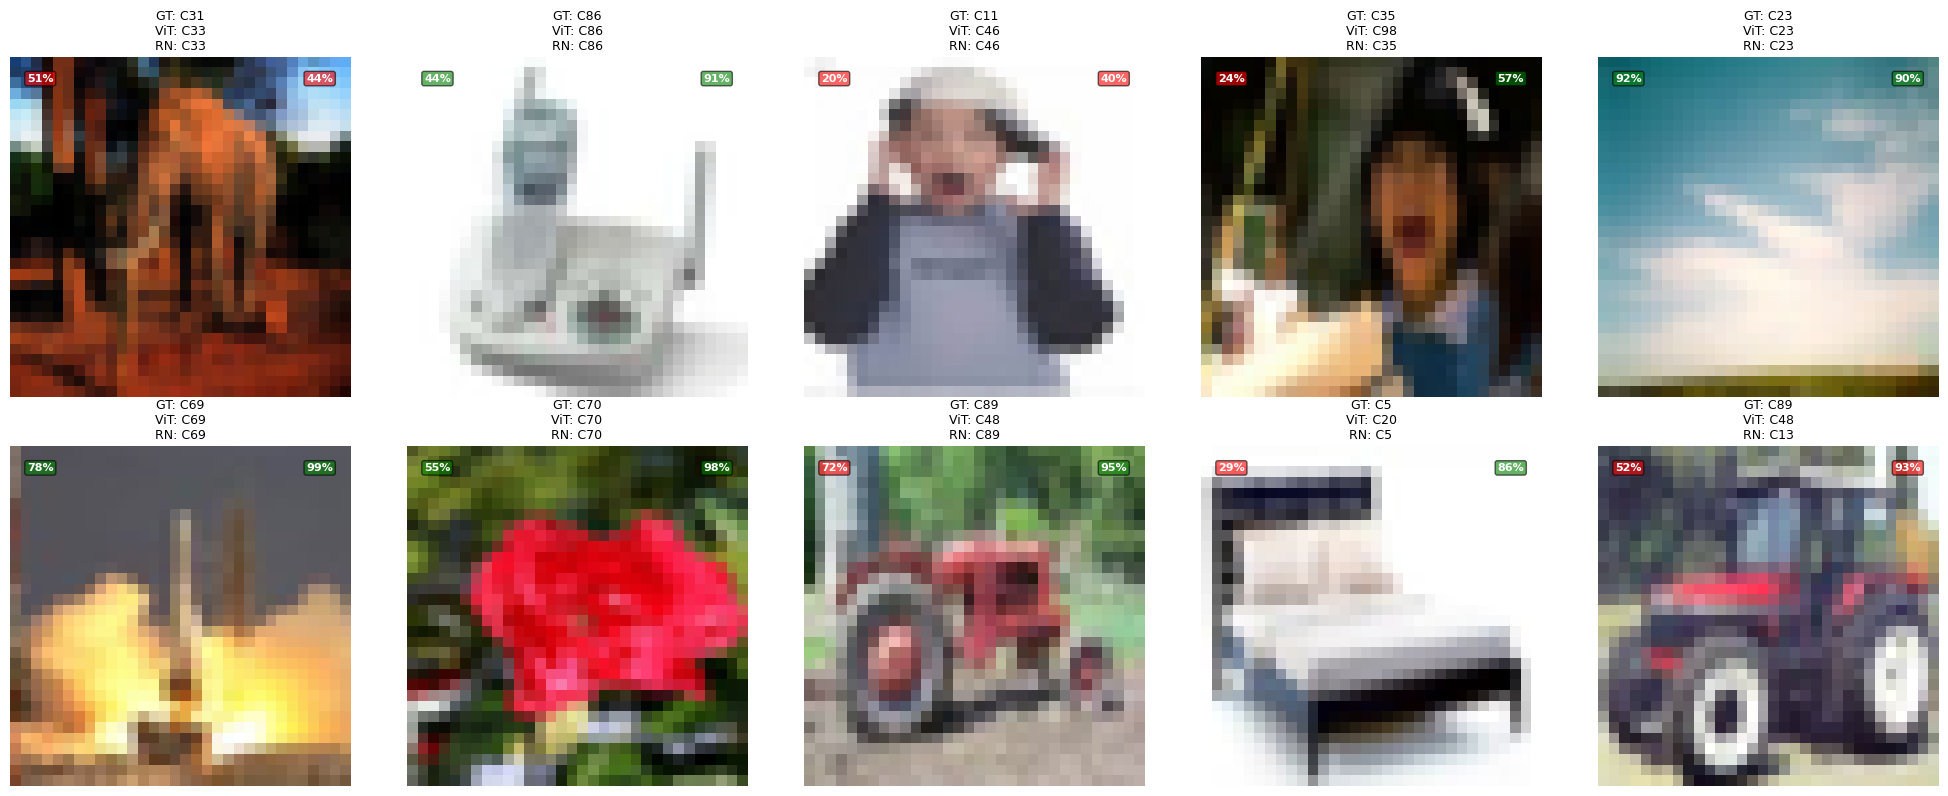


==> Model predictions saved as model_predictions.png


In [17]:
def visualize_predictions(vit_model, resnet_model, testset, classes, mean, std, num_samples=10):
    """Model prediction visualization (2x5 grid)"""
    vit_model.eval()
    resnet_model.eval()

    indices = np.random.choice(len(testset), num_samples, replace=False)

    # 2x5 grid
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    with torch.no_grad():
        for idx, sample_idx in enumerate(indices):
            img, true_label = testset[sample_idx]
            img_batch = img.unsqueeze(0).to(device)

            vit_output = vit_model(img_batch)
            resnet_output = resnet_model(img_batch)

            vit_probs = F.softmax(vit_output, dim=1)
            resnet_probs = F.softmax(resnet_output, dim=1)

            vit_pred = vit_output.argmax(dim=1).item()
            resnet_pred = resnet_output.argmax(dim=1).item()

            vit_conf = vit_probs[0, vit_pred].item() * 100
            resnet_conf = resnet_probs[0, resnet_pred].item() * 100

            img_show = denormalize(img, mean, std)
            img_show = img_show.permute(1, 2, 0).numpy()
            img_show = np.clip(img_show, 0, 1)

            axes[idx].imshow(img_show)
            axes[idx].axis('off')

            # Short class names for CIFAR-100
            if len(classes) > 10:
                true_class = f'C{true_label}'
                vit_class = f'C{vit_pred}'
                resnet_class = f'C{resnet_pred}'
            else:
                true_class = classes[true_label]
                vit_class = classes[vit_pred]
                resnet_class = classes[resnet_pred]

            vit_color = 'green' if vit_pred == true_label else 'red'
            resnet_color = 'green' if resnet_pred == true_label else 'red'

            title = f'GT: {true_class}\nViT: {vit_class}\nRN: {resnet_class}'
            axes[idx].set_title(title, fontsize=9, pad=5)

            # Confidence on image
            bbox_vit = dict(boxstyle='round,pad=0.2', facecolor=vit_color, alpha=0.6)
            axes[idx].text(0.05, 0.95, f'{vit_conf:.0f}%', transform=axes[idx].transAxes,
                          fontsize=8, verticalalignment='top', bbox=bbox_vit, color='white', fontweight='bold')

            bbox_resnet = dict(boxstyle='round,pad=0.2', facecolor=resnet_color, alpha=0.6)
            axes[idx].text(0.95, 0.95, f'{resnet_conf:.0f}%', transform=axes[idx].transAxes,
                          fontsize=8, verticalalignment='top', horizontalalignment='right',
                          bbox=bbox_resnet, color='white', fontweight='bold')

    plt.tight_layout()
    plt.savefig('model_predictions.png', dpi=200, bbox_inches='tight')
    plt.show()
    print('\n==> Model predictions saved as model_predictions.png')


# Visualization
print('\n==> Visualizing model predictions...')
visualize_predictions(vit_model, resnet_model, testset, testset.classes, MEAN, STD, num_samples=10)